# 18-819 QML Project running QVC to QiSkit

In [4]:
!pip install amazon-braket-sdk

  Using cached amazon_braket_schemas-1.22.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached amazon_braket_default_simulator-1.26.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached oqpy-0.3.7-py3-none-any.whl.metadata (8.3 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached boltons-24.1.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached openpulse-1.0.1-py3-none-any.whl.metadata (2.0 kB)
  Using cached openqasm3-1.0.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached backports.entry_points_selectable-1.3.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached antlr4-python3-runtime-4.9.2.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.3-py3-none-any.whl.metadata (1.7 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.m

In [5]:
# Use Braket SDK Cost Tracking to estimate cost
from braket.tracking import Tracker
t = Tracker().start()

### Accessing Quantum Processing Units

We will access third party QPUs to run our training on quantum hardware. 



In [7]:
!pip install qiskit_braket_provider


  Using cached qiskit_braket_provider-0.4.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_ionq-0.5.8-py3-none-any.whl.metadata (7.8 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached retry-0.9.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached charset_normalizer-3.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (34 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached py-1.11.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cach

In [8]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

# Seeing which QPUs are online
provider.backends(statuses=["ONLINE"], types=["QPU"])


ModuleNotFoundError: No module named 'backports.entry_points_selectable'

In [ ]:
qpu_backend = provider.get_backend("Aria 1")

print(qpu_backend)

### Loading the Exoplanet training data

The exoplanet training data has already been separated into X_train, X_test, y_train, y_test. 

We will use it for the training


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
X_train = np.loadtxt('middle_data/X_train.txt', delimiter=' ')
X_test  = np.loadtxt('middle_data/X_test.txt', delimiter=' ')

Y_train = np.loadtxt('middle_data/Y_train.txt', delimiter=' ')
Y_test  = np.loadtxt('middle_data/Y_test.txt', delimiter=' ')

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2000, 37)
X_test shape: (2000, 37)
Y_train shape: (2000,)
Y_test shape: (2000,)


In [11]:
print(type(X_train))

<class 'numpy.ndarray'>


### 1. Data pre-processing 

In this step, we will perform normalization of the X dataset, and label y in binary terms

In [ ]:
!/home/ec2-user/anaconda3/envs/Braket/bin/python -m pip install scikit-learn pylatexenc

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Dimensionality reduction
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Normalize data to the range [-1, 1] (use the training set to fit the scaler)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure labels are binary (if not already binary)
Y_train = (Y_train > np.median(Y_train)).astype(int)
Y_test = (Y_test > np.median(Y_test)).astype(int)

print(f"X_train shape after selection: {X_train.shape}")
print(f"X_test shape after selection: {X_test.shape}")

X_train shape after selection: (2000, 2)
X_test shape after selection: (2000, 2)


Encoding the data into quantum states

### 2. Defining the ZZFeatureMap

The ZZFeatureMap encodes the classical data into a quantum state. The depth determines the number of repeated layers in the feature map.

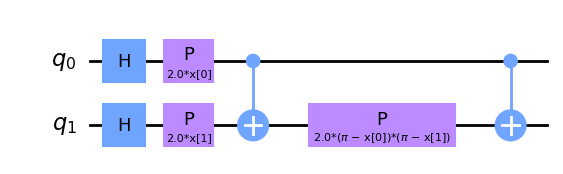

In [13]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='linear')
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### 3. Define a variational Ansatz

The variational ansatz applies trainable gates to the quantum state produced by the feature map.

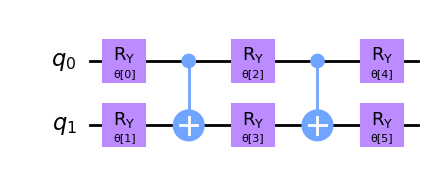

In [14]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=2, entanglement='linear')
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

### 4. Define the Model: Variational Quantum Classifier

Use the VQC (Variational Quantum Classifier) from Qiskit's machine learning module.

Documentation: https://qiskit-community.github.io/qiskit-machine-learning/_modules/qiskit_machine_learning/algorithms/classifiers/vqc.html


In [18]:
!pip install qiskit_algorithms

In [ ]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler

from tqdm import tqdm

# Initialize the optimizer
optimizer = COBYLA(maxiter=100)

# Initialize the Sampler primitive
sampler = StatevectorSampler() #backend=qpu_backend)

# Defining a callback to see the iteration
def verbose_callback(weights, objective_value):
    """
    Verbose callback function to monitor the training process during fit.

    Args:
        weights (np.ndarray): Current variational circuit parameters.
        objective_value (float): Current loss value.
    """
    print(f"Iteration: Objective Value = {objective_value:.4f}, Weights = {weights}")

# Initialize a global progress bar
progress_bar = tqdm(total=100, desc="Training Progress")  # Replace 100 with your optimizer's max iterations

def tqdm_callback(weights, objective_value):
    """
    Callback function to update the tqdm progress bar during training.

    Args:
        weights (np.ndarray): Current variational circuit parameters.
        objective_value (float): Current value of the loss function.
    """
    progress_bar.update(1)
    progress_bar.set_postfix({"Loss": objective_value})

# Build the Quantum Variational Classifier
# Num Qubits is specified as None, so that we just use the number of qubits
# specified by the quantum feature map

vqc = VQC(feature_map=feature_map, 
          ansatz=ansatz, 
          optimizer=optimizer,
          sampler=sampler,
          callback=tqdm_callback
         )

Training Progress:   0%|          | 0/100 [04:49<?, ?it/s]


### 5. Train the VQC

Now we will start training the quantum circuit

In [ ]:
vqc.fit(X_train, Y_train)


### 6. Testing of the VQC

Here, we will figure out the accuracy of the VQC, both on the train set and the test set. 


In [ ]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")